In [1]:
from keras.applications import VGG16
#Load the VGG model
image_size=150
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

Using TensorFlow backend.


In [2]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f5fa0275ac8> False
<keras.layers.convolutional.Conv2D object at 0x7f5f0899da90> False
<keras.layers.convolutional.Conv2D object at 0x7f5f08923a20> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5f08946358> False
<keras.layers.convolutional.Conv2D object at 0x7f5f08946c18> False
<keras.layers.convolutional.Conv2D object at 0x7f5f080fd518> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5f081170f0> False
<keras.layers.convolutional.Conv2D object at 0x7f5f08117dd8> False
<keras.layers.convolutional.Conv2D object at 0x7f5f080c2198> False
<keras.layers.convolutional.Conv2D object at 0x7f5f080dc550> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5f080780f0> False
<keras.layers.convolutional.Conv2D object at 0x7f5f08078dd8> False
<keras.layers.convolutional.Conv2D object at 0x7f5f08026198> False
<keras.layers.convolutional.Conv2D object at 0x7f5f0803e550> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5f0805b0f0>

In [9]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              33558528  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 12)                49164     
Total params: 48,322,380
Trainable params: 40,687,116
Non-trainable params: 7,635,264
_________________________________________________________________


In [10]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 10

train_dir='Data/Train'
validation_dir='Data/Valid'

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 903 images belonging to 12 classes.
Found 360 images belonging to 12 classes.


In [11]:
# Compile the model

model.compile(loss='cosine_proximity',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=150,
      epochs=75,
      validation_data=validation_generator,
      validation_steps=50)
 
# Save the model
model.save('small_last4.h5')

Epoch 1/75
150/150 [==============================] - 161s 1s/step - loss: -0.7051 - acc: 0.6654 - val_loss: -0.8560 - val_acc: 0.8320
Epoch 2/75
150/150 [==============================] - 138s 917ms/step - loss: -0.9210 - acc: 0.9117 - val_loss: -0.9143 - val_acc: 0.9140
Epoch 3/75
150/150 [==============================] - 139s 927ms/step - loss: -0.9658 - acc: 0.9632 - val_loss: -0.9363 - val_acc: 0.9380
Epoch 4/75
150/150 [==============================] - 138s 921ms/step - loss: -0.9813 - acc: 0.9792 - val_loss: -0.9283 - val_acc: 0.9280
Epoch 5/75
150/150 [==============================] - 138s 917ms/step - loss: -0.9907 - acc: 0.9912 - val_loss: -0.9332 - val_acc: 0.9220
Epoch 6/75
150/150 [==============================] - 138s 920ms/step - loss: -0.9948 - acc: 0.9954 - val_loss: -0.9414 - val_acc: 0.9320
Epoch 7/75
150/150 [==============================] - 138s 920ms/step - loss: -0.9961 - acc: 0.9965 - val_loss: -0.9045 - val_acc: 0.8980
Epoch 8/75
150/150 [=================

In [12]:
import numpy as np
np.save('small_last4', history.history)

In [13]:
import numpy as np
history_dict = np.load('small_last4.npy')
model.load_weights('small_last4.h5')

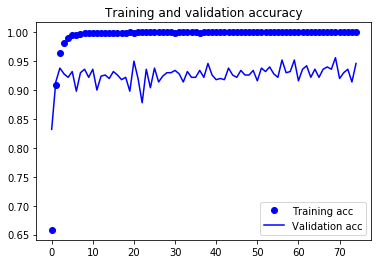

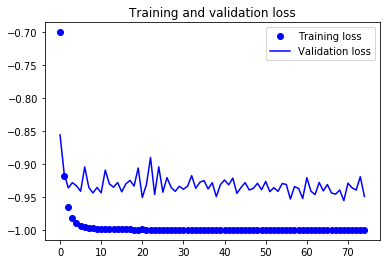

In [15]:
acc = history_dict.item().get('acc')
val_acc = history_dict.item().get('val_acc')
loss = history_dict.item().get('loss')
val_loss = history_dict.item().get('val_loss')

import matplotlib.pyplot as plt


epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()